# Логистическая регрессия

На основе набора данных об измерениях роста и веса решите следующую задачу.

Файл с данными - [Davis.csv](https://github.com/sdukshis/ml-intro/blob/master/datasets/Davis.csv)

Расширьте набор признаков добавив данные об измеренном и сообщенном весе, а также данные об поле человека.

Обратите внимание, что в некоторых строках встречаются пропуски. Это обычная ситуация при работе с реальными данными. Эти пропуски необходиму убрать из таблицы вместе со всей строкой. Это можно сделать с помощью метода [pandas.DataFrame.dropna](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html)

In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ds = pd.read_csv('https://raw.githubusercontent.com/EvgeniyPlatonov/Datasets/main/Davis.csv', index_col=0)
ds.head()

,sex,weight,height,repwt,repht
1,M,77,182,77.0,180.0
2,F,58,161,51.0,159.0
3,F,53,161,54.0,158.0
4,M,68,177,70.0,175.0
5,F,59,157,59.0,155.0


In [3]:
from sklearn.linear_model import LogisticRegression

## Задание

1. Обучите модель логистической регресси на данных, используя в качестве целевой переменной пол (sex), а в качестве признаков рост и вес (height, weight).
2. Нарисуйте точки выборки и разделяющую поверхость.
2. Оцените точность и полноту полученного решения и постройте график ROC кривой
3. Расширьте простарнство признаков квадратичными признаками.
2. Нарисуйте точки выборки и разделяющую поверхость.
2. Оцените точность и полноту полученного решения и постройте график ROC кривой

# Пункт 1

Визуализируем данные

Text(0, 0.5, 'рост, см')

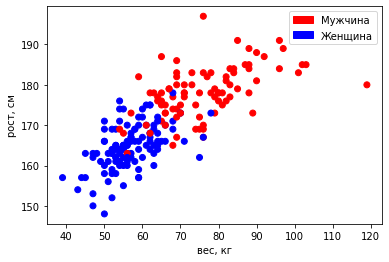

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


colors = ds['sex'].map({'M': 'r', 'F': 'b'})
plt.scatter(x=ds['weight'], y=ds['height'], c=colors)
red_patch = mpatches.Patch(color='red', label='Мужчина')
blue_patch = mpatches.Patch(color='blue', label='Женщина')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('вес, кг')
plt.ylabel('рост, см')

In [5]:
sex_map = {'M':1, 'F':0}
ds['sex'] = ds['sex'].map(sex_map)
ds.head()

,sex,weight,height,repwt,repht
1,1,77,182,77.0,180.0
2,0,58,161,51.0,159.0
3,0,53,161,54.0,158.0
4,1,68,177,70.0,175.0
5,0,59,157,59.0,155.0


Почистим датасет от пропусков

In [6]:
def clean_dataset(df):
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
ds = clean_dataset(ds)
ds.head()

,sex,weight,height,repwt,repht
1,1.0,77.0,182.0,77.0,180.0
2,0.0,58.0,161.0,51.0,159.0
3,0.0,53.0,161.0,54.0,158.0
4,1.0,68.0,177.0,70.0,175.0
5,0.0,59.0,157.0,59.0,155.0


In [7]:
from sklearn.model_selection import train_test_split

В качестве целевой переменной будет пол, зависимость будем искать от роста и веса

In [8]:
features = ds.drop(columns=['sex', 'repwt', 'repht'])
labels = ds['sex']
features.head()

,weight,height
1,77.0,182.0
2,58.0,161.0
3,53.0,161.0
4,68.0,177.0
5,59.0,157.0


Разделим данные на тренировочные и тестовые

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.35, random_state = 42, stratify = labels)

Обучим модель

In [10]:
log_reg = LogisticRegression(penalty = "l2")

In [11]:
log_reg.fit(X_train, y_train)

LogisticRegression()

In [12]:
log_reg.score(X_test, y_test)

0.921875

In [13]:
log_reg.predict(np.array([[80, 175]]))[0]

1.0

In [14]:
w1, w2 = log_reg.coef_.T
print(w1, w2)

[0.16341746] [0.28747574]


In [15]:
w0 = log_reg.intercept_
print(w0)

[-59.73822414]


## Пункт 2

Построим выборку и разделяющую кривую на одном графике

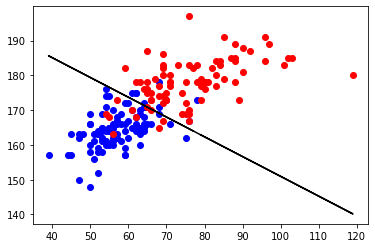

In [16]:
height = np.array(ds['height'])
weight = np.array(ds['weight'])
y = np.array(-w0/w2 - ((w1*weight)/w2))
female_weight =  np.array(ds['weight'].loc[ds['sex'] == 0])
female_height =  np.array(ds['height'].loc[ds['sex'] == 0])
male_weight =  np.array(ds['weight'].loc[ds['sex'] == 1])
male_height =  np.array(ds['height'].loc[ds['sex'] == 1])
plt.scatter(female_weight, female_height, color = 'b')
plt.scatter(male_weight, male_height, color = 'r')
plt.plot(weight, y, color = 'k')
plt.show()

## Пункт 3

Посчитаем полноту точность и полноту

In [17]:
y_hat = log_reg.predict_proba(X_test)[:, 1]
y_preds = log_reg.predict(X_test)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
print("точность=", precision)
print("полнота=", recall)

точность= 0.875
полнота= 0.9655172413793104


Построим ROC-кривую для регрессии

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

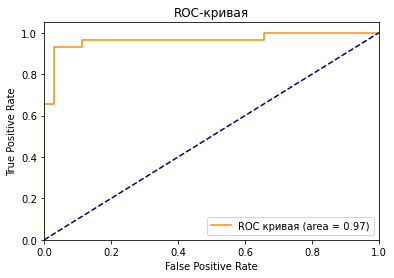

In [19]:
lr_auc = roc_auc_score(y_test, y_hat)
fpr, tpr, treshold = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

## Пункт 4

Добавим квадратичные признаки веса и роста в наши данные

In [20]:
ds['weight2'] = ds['weight']**2
ds['height2'] = ds['height']**2
ds.head()

,sex,weight,height,repwt,repht,weight2,height2
1,1.0,77.0,182.0,77.0,180.0,5929.0,33124.0
2,0.0,58.0,161.0,51.0,159.0,3364.0,25921.0
3,0.0,53.0,161.0,54.0,158.0,2809.0,25921.0
4,1.0,68.0,177.0,70.0,175.0,4624.0,31329.0
5,0.0,59.0,157.0,59.0,155.0,3481.0,24649.0


In [21]:
features = ds.drop(columns=['sex', 'repwt', 'repht'])
labels = ds['sex']
features.head()

,weight,height,weight2,height2
1,77.0,182.0,5929.0,33124.0
2,58.0,161.0,3364.0,25921.0
3,53.0,161.0,2809.0,25921.0
4,68.0,177.0,4624.0,31329.0
5,59.0,157.0,3481.0,24649.0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state = 42, stratify = labels)

In [23]:
log_reg2 = LogisticRegression(penalty = "l2")

In [24]:
log_reg2.fit(X_train, y_train)

LogisticRegression()

In [25]:
log_reg2.score(X_test, y_test)

0.9090909090909091

In [26]:
w1, w2, w3, w4 = log_reg2.coef_.T
w0 = log_reg2.intercept_
print(w0, w1, w2, w3, w4)

[-0.00336212] [-0.10374976] [-0.28718821] [0.0019547] [0.00162758]


In [27]:
y_hat1 = log_reg2.predict_proba(X_test)[:,1]
y_preds = log_reg2.predict(X_test)

## Пункт 5

Построим исходные данные и разделяющую кривую

C:\Users\Kirill\AppData\Local\Temp/ipykernel_12656/1652458320.py:5: RuntimeWarning: invalid value encountered in sqrt
  y = (-w2+np.sqrt(w2*w2 - 4*w4*(w3*we2+w1*w+w0)))/(2*w4)


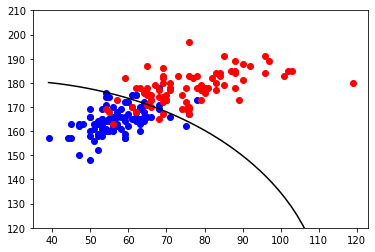

In [28]:
h = np.array(ds['height'])
w = np.array(ds['weight'])
w = np.linspace(w.min(), w.max())
we2 = w*w
y = (-w2+np.sqrt(w2*w2 - 4*w4*(w3*we2+w1*w+w0)))/(2*w4)
female_weight =  np.array(ds['weight'].loc[ds['sex'] == 0])
female_height =  np.array(ds['height'].loc[ds['sex'] == 0])
male_weight =  np.array(ds['weight'].loc[ds['sex'] == 1])
male_height =  np.array(ds['height'].loc[ds['sex'] == 1])
plt.scatter(female_weight, female_height, color = 'b')
plt.scatter(male_weight, male_height, color = 'r')
plt.plot(w, y, color = 'k')
plt.ylim (120, 210)
plt.show()

## Пункт 6

Построим ROC кривую для модели

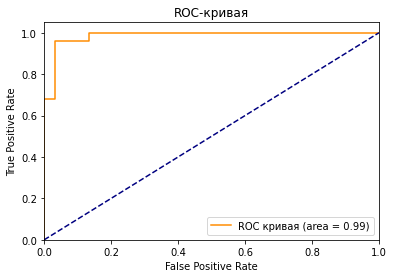

In [29]:
lr_auc = roc_auc_score(y_test, y_hat1)
fpr, tpr, treshold = roc_curve(y_test, y_hat1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Посчитаем точность и полноту

In [30]:
precision2 = precision_score(y_test, y_preds)
recall2 = recall_score(y_test, y_preds)
print("точность=", precision2)
print("полнота=", recall2)

точность= 0.8571428571428571
полнота= 0.96


## Вывод

В ходе работы я построил и обучил модель логистической регрессии с двумя признаками(рост и вес человека), модель предсказывала пол человека. Точность составила 0.875, полнота составила 0.9655172413793104. На графике 2 класса (мужчины и женщины) были разделены прямой. Затем я добавил в датасет квадрат веса и роста, обучил новую модель на новых данных точность составила 0.8709677419354839, полнота --- 0.9310344827586207. Линией разделения двух классов оказалась кривая, похожая на гиперболу. Можно сделать вывод, что при добавлении квадратичных признаков